In [1]:
import tensorflow as tf
print(f"tf.__version__: {tf.__version__}")
if tf.test.gpu_device_name(): 
    print(f"Default GPU Device:{tf.test.gpu_device_name()}")
else:
    print("Please install GPU version of TF")
from os import getcwd
import os.path
from os import listdir
import numpy as np
import pandas as pd
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns


tf.__version__: 2.1.3
Default GPU Device:/device:GPU:0


In [76]:
class WindowGenerator():

    def __init__(self, input_width, label_width, shift, train_df, val_df, test_df, label_columns=None):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, data):
        inputs = data[:, self.input_slice, :]
        labels = data[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

        
    def plot(self, model=None, plot_col='', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index], dgecolors='k', label='Labels', c='#2ca02c', s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index], marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')


        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(  data=data,
                                                                    targets=None,
                                                                    sequence_length=self.total_window_size,
                                                                    sequence_stride=1,
                                                                    shuffle=True,
                                                                    batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    def set_example(self, example_inputs, example_labels):
        self.example = example_inputs, example_labels

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result


In [63]:
datapath = Path("/home/baroncelli/phd/rtapipe/analysis/notebook_dataset_generation_for_models_output")
print(datapath)
assert datapath.is_dir() == True

/home/baroncelli/phd/rtapipe/analysis/notebook_dataset_generation_for_models_output


In [64]:
currentdir = getcwd()
currentdir

'/home/baroncelli/phd/rtapipe/analysis'

In [65]:
outdir = Path(currentdir).joinpath("notebook_lstm_output")
outdir

PosixPath('/home/baroncelli/phd/rtapipe/analysis/notebook_lstm_output')

In [66]:
SAMPLE_SIZE = 180

In [67]:
dataDir = datapath.joinpath("run0406_ID000126_OK_bkg_only","csv")
files = [  pd.read_csv(dataDir.joinpath(f), header=0) for f in listdir(dataDir) if dataDir.joinpath(f).is_file()]
# dataframe = pd.concat(li, axis=0, ignore_index=True)
# numberOfSamples = int(dataframe.shape[0]/SAMPLE_SIZE)
# dataframe = pd.DataFrame(dataframe["COUNTS"].values.reshape(numberOfSamples, SAMPLE_SIZE))

files = [  dataDir.joinpath(f) for f in listdir(dataDir) if dataDir.joinpath(f).is_file()]
dataframe = pd.read_csv(files[0], header=0)

In [68]:
dataframe.shape

(180, 5)

In [69]:
dataframe

,VALMIN,VALMAX,VALCENTER,COUNTS,ERROR
0,0,10,5.0,293,17.1172
1,10,20,15.0,235,15.3297
2,20,30,25.0,279,16.7033
3,30,40,35.0,224,14.9666
4,40,50,45.0,277,16.6433
...,...,...,...,...,...
175,1750,1760,1755.0,249,15.7797
176,1760,1770,1765.0,244,15.6205
177,1770,1780,1775.0,274,16.5529
178,1780,1790,1785.0,248,15.7480


In [70]:
n = len(dataframe)
train_df = dataframe[0:int(n*0.7)]
val_df = dataframe[int(n*0.7):int(n*0.9)]
test_df = dataframe[int(n*0.9):]

num_features = dataframe.shape[1]
num_features

5

In [71]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [72]:
train_df["CLASS"] = 0
val_df["CLASS"] = 0
test_df["CLASS"] = 0

In [73]:
train_df.head()

,VALMIN,VALMAX,VALCENTER,COUNTS,ERROR,CLASS
0,-1.711363,-1.711363,-1.711363,1.992335,1.937933,0
1,-1.683760,-1.683760,-1.683760,-1.664483,-1.682459,0
2,-1.656157,-1.656157,-1.656157,1.109655,1.099622,0
3,-1.628555,-1.628555,-1.628555,-2.358017,-2.417880,0
4,-1.600952,-1.600952,-1.600952,0.983558,0.978099,0


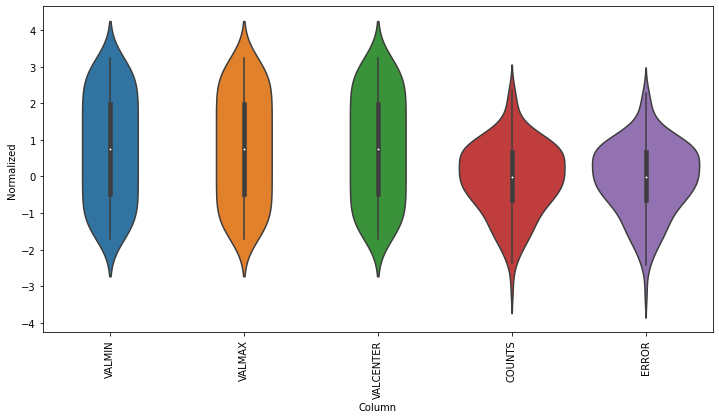

In [74]:
df_std = (dataframe - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(dataframe.keys(), rotation=90)

In [80]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=0, train_df=train_df, test_df=test_df, val_df=val_df, label_columns=['CLASS'])

example_window = tf.stack([np.array(train_df[:w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)
#w2.set_example(example_inputs, example_labels)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')
print(example_inputs)
print(example_labels)

All shapes are: (batch, time, features)
Window shape: (1, 6, 6)
Inputs shape: (1, 6, 6)
labels shape: (1, 1, 1)
tf.Tensor(
[[[-1.71136259 -1.71136259 -1.71136259  1.99233512  1.93793291
    0.        ]
  [-1.68375996 -1.68375996 -1.68375996 -1.66448251 -1.68245939
    0.        ]
  [-1.65615734 -1.65615734 -1.65615734  1.10965501  1.09962221
    0.        ]
  [-1.62855472 -1.62855472 -1.62855472 -2.35801689 -2.41788006
    0.        ]
  [-1.6009521  -1.6009521  -1.6009521   0.98355785  0.97809855
    0.        ]
  [-1.57334948 -1.57334948 -1.57334948 -0.34046233 -0.3248376
    0.        ]]], shape=(1, 6, 6), dtype=float64)
tf.Tensor([[[0.]]], shape=(1, 1, 1), dtype=float64)


In [81]:
w2.plot(plot_col="COUNTS")

AttributeError: module 'tensorflow_core.keras.preprocessing' has no attribute 'timeseries_dataset_from_array'

In [61]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

AttributeError: module 'tensorflow_core.keras.preprocessing' has no attribute 'timeseries_dataset_from_array'